Firstly the relevent packages must be loaded.

In [1]:
# kinetics package for doing the modelling
# Requires SALib and tqdm
import kinetics

# General packages used in this notebook
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
%matplotlib inline
from matplotlib import pyplot as plt

# Set up the model

## 1.  -  Define reaction classes for the model reactions
Firstly define your reactions as classes as shown in the code example below.  
For example an enzyme catalysed reaction (eg class Esterase_r1() shown below), or a chemical reaction.

### 1.1  -  Parameters
Reactions have parameters which are used to calculate the rate of reaction.

Each class must have a parameter_defaults and a parameter_bounds defined.  
These will be incorporated into the model.parameter_defaults and model.parameter_bounds later.
(It is therefore sensible to include the enzyme name when naming parameters)

The defaults are the values for each parameter with no error.  The bounds are an lower and upper value between which the true parameter value is likely to be - this is used for the uncertainty and sensitivity analysis.  

Parameter_defaults and parameter_bounds can be set from a single 'parameters' dictionary (as in the example), which specifies the default value, and an associated error.  The error can be either std error, or percentage error.

The 'parameters' dictionary in this example will not be used in the model, but is used to set the parameter_defaults and parameter_bounds, which are required.

If no bounds are set for a parameter, the default value will be used in the uncertainty and sensitivity analysis.  If the std_error in 'parameters' is set to 0, no bounds will be returned when using kinetics.get_bounds_from_std_error(parameters).

### 1.2  -  def reaction(self, y, substrate_names, parameters) function
Every reaction class must have a reaction function.
This function always takes self, y, substrate_names, parameters as arguments in this order.

When the model is run, each reaction function is called in turn to calculate the changing substrate concentrations.  


##### 1.2.1  -  Substrates
Firtly, substrate concentrations needed to calculate the rate and taken from y.  To do this the index of the relevent substrate in substrate_names is used to get that substrates concentration in y.

(eg ester = y[substrate_names.index("Ester")])

##### 1.2.2  -  Parameters
Secondly, parameters are retrieved from the parameters dictionary which was included as one of the arguments for the function.  This is done so that parameters can be changed easily in the model to facilitate the uncertainty and sensitivity analysis, rather than setting the parameters statically in the function.

##### 1.2.3  -  Rate equation
Thirdly, the rate is calculated using an appropriate rate function.  Custom rate functions can be included here, either directly or as an additional function.

##### 1.2.4  -  Calulate changes in substrate concentrations and return y_prime
Finally, y_prime is determined.  Substrates which are used up in the reaction have their concentration decreased by the rate, and products who are produced in the reaction have their concentration increased by the rate.


In [2]:
class Esterase_r1():
    parameters = {"afest_km_ester": (1500, 200),
                  "afest_kcat": (6, 1)}

    parameter_defaults = kinetics.set_parameter_defaults(parameters)
    parameter_bounds = kinetics.get_bounds_from_std_error(parameters)

    def reaction(self, y, substrate_names, parameters):
        # Substrates
        ester = y[substrate_names.index("Ester")]
        esterase = y[substrate_names.index("Esterase_Enzyme")]
        
        # Parameters
        est_kcat = parameters["afest_kcat"]
        est_km = parameters["afest_km_ester"]
        
        # Rate equation
        rate = kinetics.one_substrate_mm(kcat = est_kcat,
                                         km_a = est_km,
                                         enz = esterase,
                                         a = ester)

        # Calculate change in substrate concentrations
        substrates = ["Ester"]
        products = ["Acid", "Methanol"]
        y_prime = kinetics.calculate_yprime(y, rate, substrates, products, substrate_names)

        return y_prime

## 2.  -  Define starting substrate concentrations

All substrates must be defined.  If the starting substrate concentration is 0 it is set at this.

Where the starting concentration is not 0, an error can be associated with this value.
Typically a percentage error is used, with a small error of +/- 5 %  (0.05)

When the starting concentration is more uncertain, larger error can be associated.

As with the parameters, species_defaults and species_bounds are required by the model.
These can be determined from a single 'substrates' dictionary which includes the default value and the associated error.  The bounds are then calculated from this value and error.

In [3]:
substrates = {"Ester": (2800, 0.05),
               "Acid" : (0, 0),
               "Esterase_Enzyme": (10, 0.05),
               "Methanol": (0, 0)
              }

species_defaults = kinetics.set_species_defaults(substrates)
species_bounds = kinetics.get_bounds_from_pc_error(substrates)

## 3. - Create the model object, and load the reactions and substrate concentrations

Create a model from the kinetics.Model() class.  The species_defaults and species_bounds can then be set as shown below.  The timecourse the model should be run over is set, along with the number of timepoints or steps.

The reaction classes are then appended to the model.  In this case we append the Esterase_r1() class we defined in section 1.
Once all the reaction classes are added, the parameters for each reaction class are loaded into the model.

In [4]:
""" ------------------- MODEL  ------------------- """
model = kinetics.Model()

model.set_species_defaults(species_defaults)
model.set_species_bounds(species_bounds)

""" ------------------- MODEL TIME SETTINGS  ------------------- """
start = 0
end = 240
number_steps = 16
model.set_time(start, end, number_steps, mxsteps=10000)

""" ------------------- MODEL REACTION FUNCTIONS  ------------------- """
model.append(Esterase_r1())

# Set model parameters for appended reactions
model.set_parameters_from_reactions()

Great, now the model is all set we can run the uncertainty and sensitivity analysis.

# Uncertainty analysis

An uncertainty analysis object (ua in the example) is first created from the kinetics.UA class.  This requires a model as an argument, with the option to also specify the number of samples to take and the quartile range to return.

Latin hypercube sampling is used by calling ua.make_lhc_samples().  This samples values from within the parameter and substrate bounds.

The sampled values for the parameters and substrates are run through the model with the output for each saved, by calling ua.run_models().

The quartiles (eg 5th and 95th), and mean for all the model runs are determined by calleding ua.caluclate_quartiles().  The quartiles are saved in ua.quartile_output and as a pandas dataframe for each substrate in ua.substrate_dataframes.  ua.substrate_dataframes is a dictionary of pandas dataframes, with the substrate name as the key.  (ua.substrate_datafraomes['Ester'] would return the dataframe for the ester quartiles)

In [5]:
ua = kinetics.UA(model,
                 num_samples=1000,
                 quartile_range=95)
ua.make_lhc_samples()
ua.run_models()
ua.calculate_quartiles();

self.problem, self.samples and self.parsed_samples set by lhc
running all models


100%|██████████| 1000/1000 [00:01<00:00, 632.96it/s]


samples run, model outputs saved in self.output
quartiles calculated, saved in self.quartile_output
Quartiles for each substrate saved to self.substrate_dataframes


#### Plot the quartiles
With 1000 models run and the quartiles calculated, we can plot the substrates we are interested in. 

A dictionary of 'substrate_colours' is used to define the colours for each substrate on the graph. A dictionary of 'substrate_symbols' is used to define symbols to be used when plotting experimental data.  A list of 'substrates' defines which substrates should be plotted.

kinetics.set_graph_settings() changes a number of matplotlib default settings to make a better looking graph.  kinetics.setup_ua_graph sets up the graph axis.

kinetics.add_ua_model_to_graph plots the relevent substates on the graph, with thin dotted lines used for the quartiles, and a thick line for the mean.  A legend can be added by calling plt.legend()

Experimental data can also be plotted.  This is loaded 

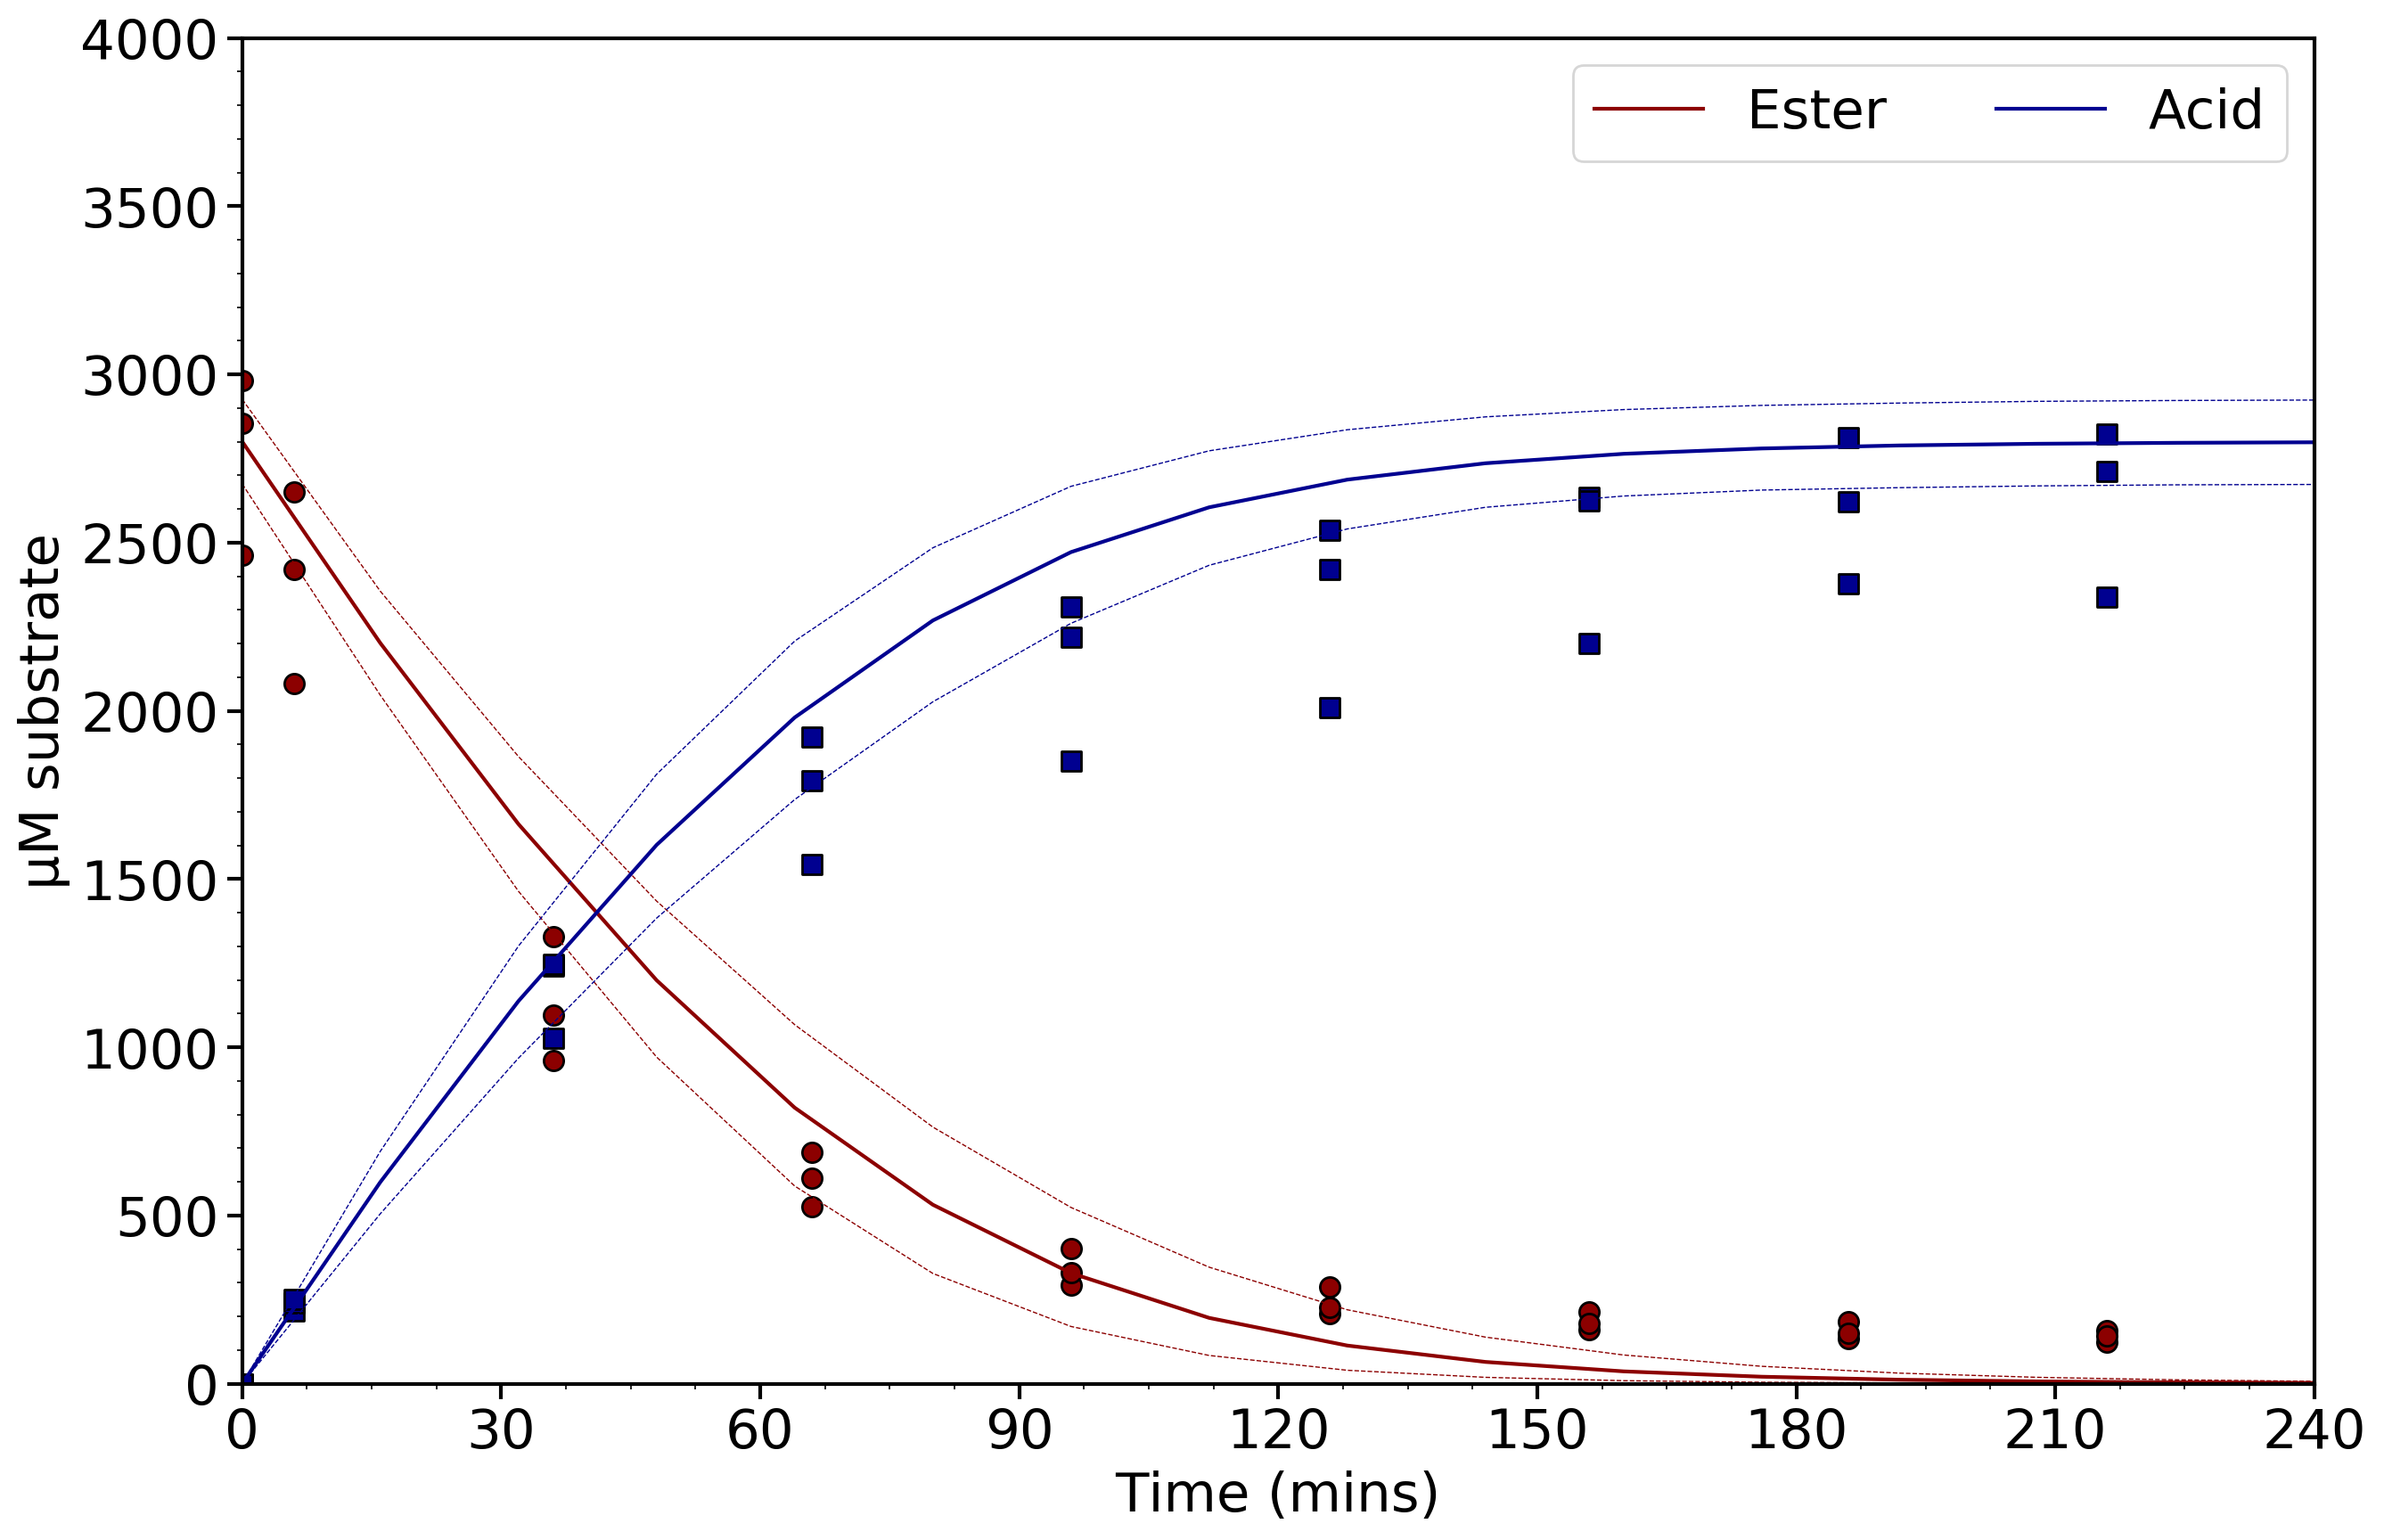

In [6]:
# Set substrate colours and substrates to plot
substrate_colours = {"Ester" : "#8C0000",
                     "Acid" : "#000090"}

substrate_symbols = {"Ester" : "o",
                     "Acid" : "s"}

substrates = ["Ester", "Acid"]

# Change matplotlib default settings and set the graph axis
kinetics.set_graph_settings()
kinetics.setup_ua_graph(y_max=4000, x_max=240, y_tick=500, x_tick=30)

# Add the uncertainty analysis quartiles to the graph
kinetics.add_ua_model_to_graph(substrates, ua.substrate_dataframes, substrate_colours)
plt.legend(ncol=4);

# Add experimental data to the graph
exp_data = pd.read_excel('experimental_data.xlsx', 'esterase_only')
kinetics.add_experimental_data_to_graph(substrates, exp_data, substrate_colours, substrate_symbols)

# Show the graph
plt.show()

## Sensitivity Analysis

In [7]:
timepoint_for_analysis = 240
substrate_for_analysis = "Acid"

sa = kinetics.SA(model,
                 number_samples=500,
                 second_order=False,
                 conf_level=0.95,
                 num_resample=100)

sa.make_saltelli_samples()
sa.run_models()
sa.analyse_sobal_sensitivity_substrate_concentration_at_t(timepoint_for_analysis,
                                                          substrate_for_analysis);

self.problem, self.samples and self.parsed_samples set by make_saltelli_samples
running all models


100%|██████████| 3000/3000 [00:04<00:00, 602.03it/s]


samples run, model outputs saved in self.output
self.output_for_analysis updated with outputs for substrate Acid at timepoint 240
self.analysis updated with sobal sensitivity analysis output
Sobal sensitivity analysis saved as dataframe in self.dataframe_output


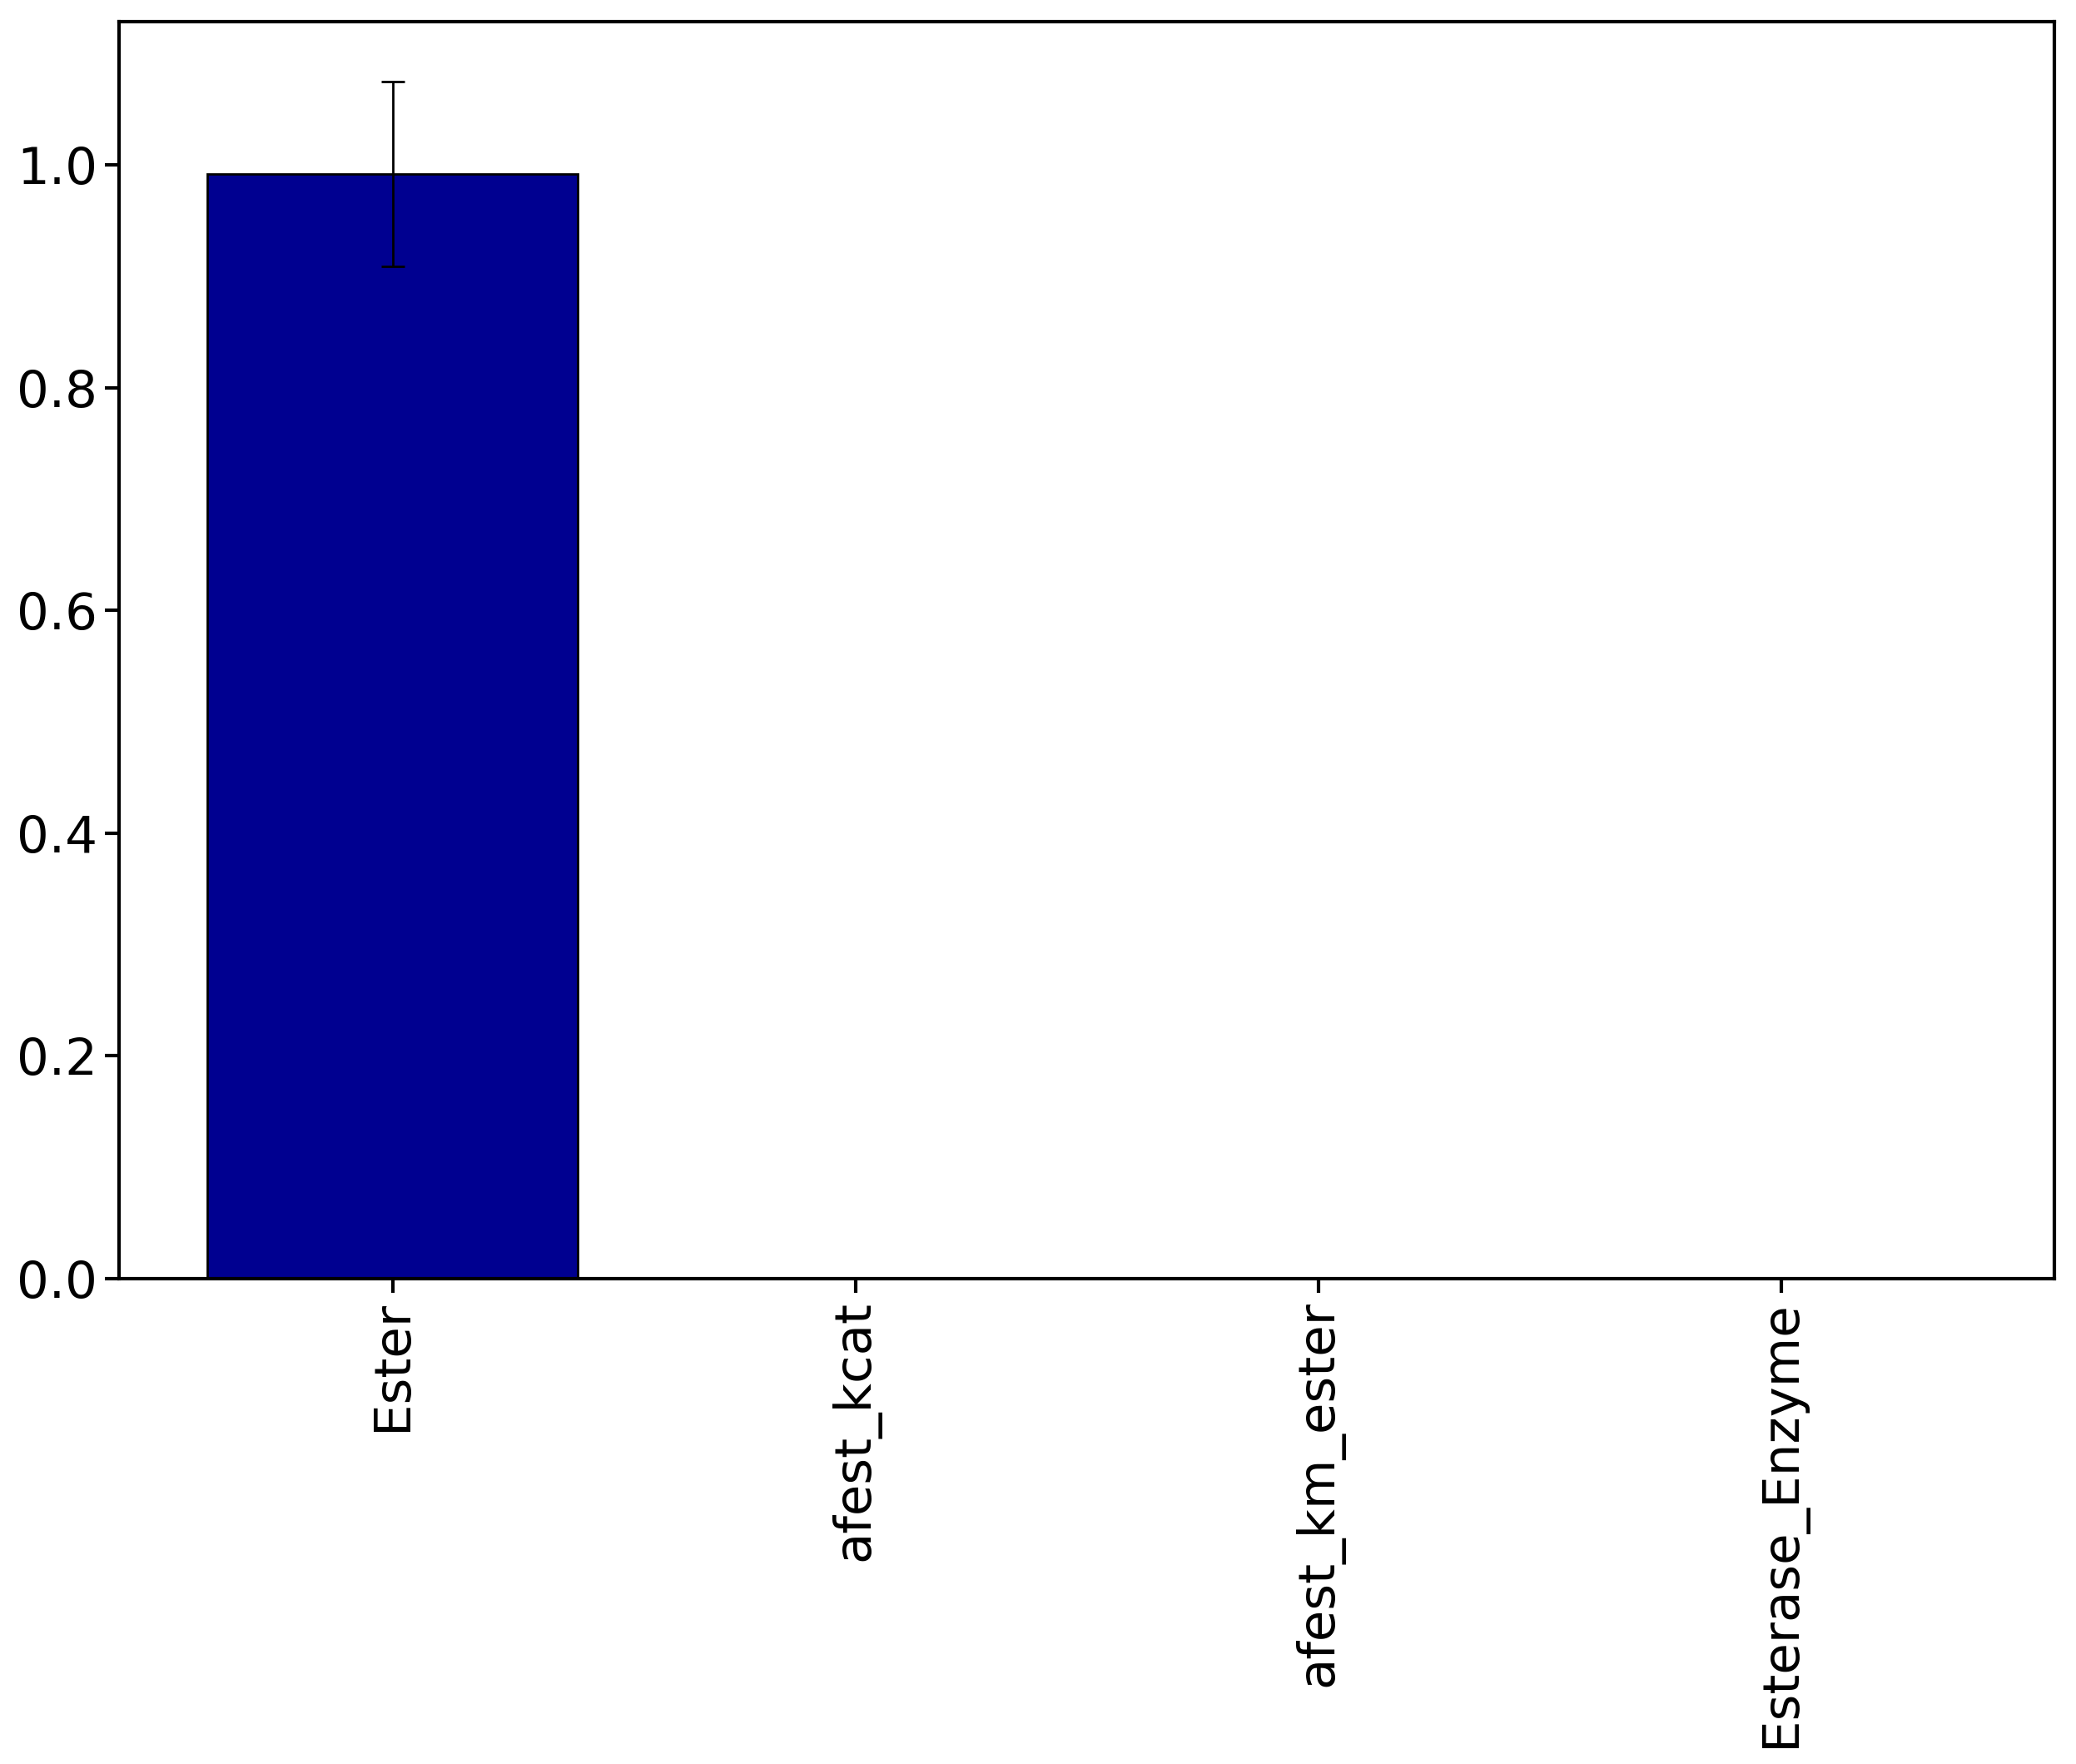

In [8]:
# filtered_df = kinetics.remove_st_less_than(sa.dataframe_output, column='ST', less_than=0.001)
filtered_df = sa.dataframe_output.sort_values("ST", ascending=False)

kinetics.plot_sa_total_sensitivity(filtered_df)
plt.show()